<a href="https://colab.research.google.com/github/shaikadish/twitterTopicModeling/blob/main/twitterTopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd drive/MyDrive/twitterTopicModeling

Mounted at /content/drive
/content/drive/MyDrive/twitterTopicModeling


In [ ]:
def get_conversation_query_params(conversation_id, max_result=5000):
    return  {'query': 'conversation_id:{}'.format(conversation_id),
            'tweet.fields': 'author_id,conversation_id,created_at,in_reply_to_user_id,lang,referenced_tweets',
            'user.fields': 'id,created_at,username,name,description,location,public_metrics,url,verified,entities',
            'expansions': 'author_id,in_reply_to_user_id,referenced_tweets.id',
            'max_results': max_result
            }

def get_tweet_query_params():
    return  {
            'tweet.fields': 'author_id,conversation_id,created_at,in_reply_to_user_id,lang,referenced_tweets',
            'user.fields': 'id,created_at,username,name,description,location,public_metrics,url,verified,entities',
            'expansions': 'author_id,in_reply_to_user_id,referenced_tweets.id',
            }

def get_followers_query_params(max_results = 100):
    return {'user.fields': 'id,created_at,username,name,description,location,public_metrics,url,verified,entities',
            'max_results':max_results}

def get_user_query_params():
    return {'user.fields':'id,created_at,username,name,description,location,public_metrics,url,verified,entities'}

def get_recent_search_query_params(search_query,start_time,end_time, max_results = 100):

    return {'query': f"{search_query} lang:en -is:retweet",
            #'granularity': granularity,
            'start_time': start_time,
            'end_time': end_time,
            'user.fields': 'id,created_at,username,name,description,location,public_metrics,url,verified,entities',
            'tweet.fields': 'author_id,in_reply_to_user_id,created_at,conversation_id,public_metrics,lang,geo,referenced_tweets,entities',
            'expansions': 'author_id',
            'max_results': max_results}

In [ ]:
import json
import os
import time

import requests
import dateutil.parser as parser

bearer_token = 'AAAAAAAAAAAAAAAAAAAAAMp9TQEAAAAAmH4NuulUuo2z0lX5kaHfD4yU6u8%3Dq0Z1rZjc9GBkc7sssQ8ni1eyYz7DDtPjnWRSUxAb8iqnubyH10'
headers = {"Authorization": "Bearer {}".format(bearer_token)}

def count_recent_tweets(search_query, granularity='day', start_time=None, end_time=None) -> dict:
    url = "https://api.twitter.com/2/tweets/counts/recent"
    if start_time:
       start_time = parser.parse(start_time).isoformat()+'Z'
    if end_time:
        end_time = parser.parse(end_time).isoformat()+'Z'

    params = {'query': search_query,
              'granularity': granularity,
              'start_time': start_time,
              'end_time': end_time}
    return requests.request("GET", url, headers=headers, params=params).json()


def recent_search_lookup(search_query,granularity='day', start_time=None, end_time=None, max_count = 50) -> dict:
    url = "https://api.twitter.com/2/tweets/search/recent"

    if start_time:
       start_time = parser.parse(start_time).isoformat()+'Z'
    if end_time:
        end_time = parser.parse(end_time).isoformat()+'Z'

    params = get_recent_search_query_params('#'+' #'.join(search_query),start_time,end_time)
    all_responses = []
    response = requests.request("GET", url, headers=headers, params = params).json()
    all_responses.extend(response['data'])
    time.sleep(2)
    id_list=[]
    
    while 'next_token' in response['meta'] and len(all_responses) < max_count:
        params['next_token'] = response['meta']['next_token']
        response = requests.request("GET", url, headers=headers, params = params).json()
        
        time.sleep(2)
        '''
        for r in response['data']:
          follower_count=get_user_profile(r['author_id'])
          print(follower_count)
          time.sleep(4)
          if follower_count['data']['public_metrics']['followers_count']>500:
            data_copy.append(r)
        
        response['data']=data_copy
        '''
          
        all_responses.extend(response['data'])

    return all_responses

def conversation_lookup(conversation_id, timeout=2) -> dict:
    params = query_params.get_conversation_query_params(conversation_id)
    url = 'https://api.twitter.com/2/tweets/search/recent'
    results = requests.request("GET", url, headers=headers, params=params).json()
    time.sleep(timeout)
    if results['meta']['result_count'] == 0:
        return
    new_results = results.copy()
    while 'next_token' in new_results['meta']:
        params['next_token'] = new_results['meta']['next_token']
        new_results = requests.request("GET", url, headers=headers, params=params).json()
        results['data'].extend(new_results['data'])
        results['includes']['users'].extend(new_results['includes']['users'])
        if 'tweets' in new_results['includes']:
            results['includes']['tweets'].extend(new_results['includes']['tweets'])
        time.sleep(timeout)
    return results

def tweet_lookup(tweet_id, timeout=2) -> dict:
    url = 'https://api.twitter.com/2/tweets/{}'.format(tweet_id)
    params = query_params.get_tweet_query_params()
    time.sleep(timeout)
    return requests.request("GET", url, headers=headers, params=params).json()


def get_user_profile(user_id, update = False, timeout=6):
    url = "https://api.twitter.com/2/users/{}".format(user_id)    
    params = get_user_query_params()
    response = requests.request("GET", url, headers=headers, params = params).json()
    return response


def followers_lookup(user_id):
    url = "https://api.twitter.com/2/users/{}/followers".format(user_id)
    params = query_params.get_followers_query_params()

    all_responses = []
    response = requests.request("GET", url, headers=headers, params = params).json()
    all_responses.append(response)
    time.sleep(60)
    while 'next_token' in response['meta']:
        next_token = response['meta']['next_token']
        query_params['pagination_token'] = next_token
        response = requests.request("GET", url, headers=headers, params = params).json()
        all_responses.append(response)
        time.sleep(60)

    return all_responses

In [193]:
import json
import datetime

from requests.api import get
from datetime import datetime


def get_tweets(hashtags: list,
               period: int):
    """
    A function to retrieve all tweets from a historical period.
    
    :param hashtags: The list of hashtags to search for
    :param period: The number of days before today to search for tweets
    """
    today=datetime.now()
    today=today.strftime("%m/%d/%Y") # Currently taking from midnight to midnight, could do some messing around to get it to be current
    begin_period=today.split('/')
    if int(begin_period[1])<=period:
        begin_period[0]=str(int(begin_period[0])-1)
        begin_period[1]=str(31-period)
    else:
        begin_period[1]=str(int(begin_period[1])-period)
    begin_period='/'.join(begin_period)
    return recent_search_lookup(hashtags,start_time=begin_period,end_time=today,max_count=1000)
 
#a=get_tweets(['f1'],5)

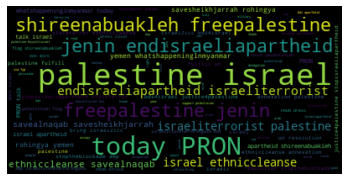

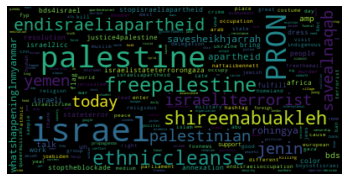

In [ ]:
import spacy
from wordcloud import WordCloud
import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def clean_text(text,nlp):
    #nlp = spacy.load("en_core_web_sm")
    stops=nlp.Defaults.stop_words
    stops |= {'.','-','?','_','!','...','-',':',',',';','\"','&',']','[','(',')','\''}
    text=text.lower()
    text=remove_emoji(text)
    doc = nlp(text)
    lemmatized=list()
    for word in doc:
        if '@' in word.text:
            continue
        if '#' in word.text:
            continue
        if 'https' in word.text:
            continue
        lemma=word.lemma_.strip()
        if lemma:
            if lemma not in stops:
                lemmatized.append(lemma)
    return " ".join(lemmatized)


def show_wordcloud(text: list,
                   pos: list):
    """
    A function to display a wordcloud of one or more parts of speech.
    
    :param text: The list of tweet texts
    :param pos: One or more parts of speech tags to include in the wordcloud
    """
    #Generate a word cloud image
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40,collocations=False).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    # Cool stuff goes here

tweets=get_tweets(['Israel','Palestine'],1)
text=[]
nlp = spacy.load("en_core_web_sm")
for tweet in tweets:
    text.append(clean_text(tweet['text'],nlp))
corpus=" ".join(text)
docs=list(nlp.pipe(text))
show_wordcloud(corpus,[1])

In [ ]:
!pip install sentence_transformers
!pip install pysentimiento
!pip install pyyaml==5.4.1
!pip install umap-learn
!pip install hdbscan

In [194]:
from matplotlib.pyplot import get
import numpy as np
import spacy
from sentence_transformers import SentenceTransformer
import umap
from pysentimiento.preprocessing import preprocess_tweet
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd


def get_tweet_embedding(text):
    """
    A function to embed a set of tweets into an embedding space.
    
    :param text: The list of tweet texts
    :return: The set of embedding vectors
    """
    model=SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    embedding=[]
    for tweet in text:
        embedding.append(model.encode(tweet))
    embedding=np.array(embedding)
    return embedding

def visualise_embedding(vectors):
    """
    A function to reduce and visualise an embedding space.
    
    :param vectors: A set of vectors to visualise
    """
    fit=umap.UMAP(n_components=3,n_neighbors=15,metric='cosine')
    ax=plt.axes(projection='3d')
    reduced_data=fit.fit_transform(vectors)
    ax.scatter3D(reduced_data[:,0],reduced_data[:,1],reduced_data[:,2])
    fig=px.scatter_3d(pd.DataFrame(reduced_data),x=0,y=1,z=2)
    fig.show()

def get_text(tags=['f1']):
    tweets=get_tweets(tags,6)
    text=[]
    #nlp = spacy.load("en_core_web_sm")
    stops={'emoji','url','@usuario','usuario'}
    for tweet in tweets:
      line_list=preprocess_tweet(tweet['text'],lang="en",user_token='',url_token='').split('\n')
      if line_list[0][0]=='[' and line_list[0][-1]==']':
        line_list=line_list[1:]
      new_text=' '.join(line_list)
      new_text=' '.join([word for word in new_text.split(' ') if  not(word in stops)])
      text.append(new_text)
    return text

#visualise_embedding(get_tweet_embedding(get_text()))

In [ ]:
#tweets=get_tweets(['f1'],6)
text=[]
#nlp = spacy.load("en_core_web_sm")
stops={'emoji','url','@usuario','usuario','HTTPURL'}
def word_checks(word):
  if word=='@user' or word=='@USER':
    word='User'
  return word

for tweet in tweets:
    line_list=preprocess_tweet(tweet['text'],lang="en",user_token='',url_token='').split('\n')
    if line_list[0][0]=='[' and line_list[0][-1]==']':
      line_list=line_list[1:]
    new_text=' '.join(line_list)
    new_text=' '.join([word_checks(word) for word in new_text.split(' ') if  not(word in stops)])
    text.append(new_text)

In [195]:
text=get_text(tags=['f1'])
tweet_embeddings=get_tweet_embedding(text)

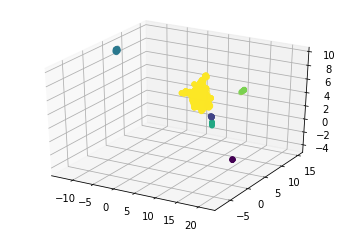

In [215]:
import numpy as np
import umap
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt

def get_topics(vectors):
    """
    A function to uncover the topics present in a text embedding.
    
    :param vectors: A set of embedding vectors
    :return: The uncovered topics and their associated scores
    """
    fit=umap.UMAP(n_components=5,n_neighbors=15,metric='cosine')
    reduced_data=fit.fit_transform(vectors)
    cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(reduced_data)
    fit=umap.UMAP(n_components=3,n_neighbors=15,metric='cosine')
    reduced_data=fit.fit_transform(vectors)
    result=pd.DataFrame(reduced_data,columns=['x','y','z'])
    result['labels']=cluster.labels_
    clustered=result.loc[result.labels!=-1]
    ax=plt.axes(projection='3d')
    ax.scatter3D(clustered.x,clustered.y,clustered.z,c=clustered.labels)
    # Cool stuff goes here
    
    return cluster.labels_

def get_topic_clusters(tweet_embeddings):
    return get_topics(tweet_embeddings)

labels=get_topic_clusters(tweet_embeddings)

In [224]:
data={'tweet':text,'label':labels}
df=pd.DataFrame(data=data)
df[df['label']==5]

,tweet,label


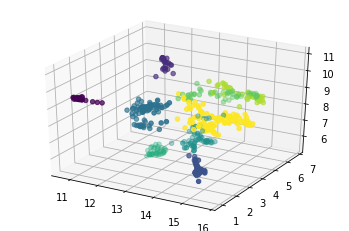

In [225]:
data={'tweet':text,'label':labels}
df=pd.DataFrame(data=data)
new_text=pd.Series(text)[df.label==5].to_list()
new_vectors=tweet_embeddings[df.label==5]
new_labels=get_topic_clusters(new_vectors)

In [227]:
data={'tweet':new_text,'label':new_labels}
new_df=pd.DataFrame(data=data)
new_df[new_df.label==-1]

,tweet,label
1,Such a magical place to be (especially around ...,-1
5,Checo had enough f1 formula1 f1 news,-1
18,"Hey , karma's a bitch! Kissing butt is now yo...",-1
19,Charles concentrates on positives despite Spai...,-1
20,I've noticed that if Charles had played it saf...,-1
...,...,...
812,My poor tyre didnt fair so well yesterday. Mas...,-1
813,Vettel: So slow in Spain it was Formula 2 qual...,-1
814,"Walk away from , rather than helping them win ...",-1
816,F1 BIGGEST CRASH - 2011 fearful face fearful...,-1


In [124]:
!git clone https://github.com/MaartenGr/cTFIDF.git

Cloning into 'cTFIDF'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 11), reused 19 (delta 5), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [243]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from cTFIDF.ctfidf import CTFIDFVectorizer
from nltk.corpus import stopwords

# Get data and create documents per label)
docs_per_class = new_df.groupby(['label'],as_index=False).agg({"tweet":' '.join})
for doc in docs_per_class.iterrows():
  doc=doc[1]
  new_corpus=[]
  for word in doc.tweet.split(' '):
    if not(word in stopwords.words('english')):
      new_corpus.append(word)
  docs_per_class.loc[docs_per_class.label==doc.label,'tweet']=' '.join(new_corpus)
  print(docs_per_class.loc[docs_per_class.label==doc.label,'tweet']==' '.join(new_corpus))

# Create c-TF-IDF
count_vectorizer = CountVectorizer().fit(docs_per_class.tweet)
count=count_vectorizer.transform(docs_per_class.tweet)
words=count_vectorizer.get_feature_names()

ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(new_df)).toarray()
words_per_class = {str(label): [words[index] for index in ctfidf[label].argsort()[-10:]] for label in docs_per_class.label}

In [276]:
words_per_class

{'-1': ['review',
  'the',
  'podcast',
  'weekend',
  'red',
  'prix',
  'grand',
  'spain',
  'gp',
  'spanish'],
 '0': ['hamilton',
  'alonso',
  'mercedes',
  'team',
  'race',
  'face',
  'formula1',
  'gp',
  'f1',
  'spanish'],
 '1': ['scooter',
  'thieves',
  'martin',
  'robbed',
  'stolen',
  'aston',
  'barcelona',
  'bag',
  'sebastian',
  'vettel'],
 '2': ['if',
  'seven',
  'season',
  'christian',
  'miss',
  'horner',
  'races',
  'teams',
  'cap',
  'budget'],
 '3': ['spanish',
  'damaged',
  'engine',
  'pu',
  'leclercs',
  'turbo',
  'mgu',
  'failure',
  'leclerc',
  'ferrari'],
 '4': ['win',
  'team',
  'he',
  'gp',
  'spanish',
  'checo',
  'verstappen',
  'hamilton',
  'lewis',
  'max'],
 '5': ['grand',
  'ferrari',
  'prix',
  'race',
  'face',
  'week',
  'charles',
  'leclerc',
  'gp',
  'monaco'],
 '6': ['lap',
  'day',
  '23',
  'may',
  'prix',
  'grand',
  'carlo',
  'monte',
  '1982',
  'monaco'],
 '7': ['sale',
  'pre',
  'car',
  'go',
  'nfts',
  '24

In [ ]:
def get_sentiment(text: str) -> float:
    """
    A function to predict the sentiment of a piece of text.
    
    :param text: The text
    :return: The sentiment score
    """
    tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
    model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
    inputs=tokenizer(text,return_tensors='pt')
    outputs=model(**inputs) # output [NEG,NEU,POS]
    # Cool stuff goes here
    
    return [i.item() for i in outputs.logits[0]]